Hello ! 

In this kernel, i will try to estimate a model that explains the torque and the stator_winding variables in the dataset. I will use correlation to be able to figure what are the variables that has the more effect on the two outputs (torque and stator_winding). This will help reduce the quantity of variables used and also simply the models which is always the best thing to do (the best models are the simplest models).
I won't be splitting the datasets to training and testing datasets but i would rather use each profile as a seperate experiment and then compare the models' parameters estimated to see their consistency.

Hope that you will enjoy my kernel !

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from random import randint
from sklearn.linear_model import LinearRegression

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/electric-motor-temperature/pmsm_temperature_data.csv


Read the data and assign it to a dataframe :

In [2]:
df = pd.read_csv(os.path.join(dirname, filename))

Having a look at the first row of the dataframe

In [3]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


**Data Exploration and Analysis**

Let's check some information about the dataset and see if there is any NaN or missing values in the columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


That is good news ! It does not look like there is missing values and there are no NaN.

So each profile is actually an experiment that was conducted and the measures were recorded during each experiment. Let's see how many experiment we have

In [5]:
# Get the unique profile IDs
unique_profiles_id = df['profile_id'].unique()

print('Number of unique profiles: %i'%len(unique_profiles_id))

Number of unique profiles: 52


There are the records on 52 experiments and as it was stated in the introduction of the dataset they are all independant. We can now look at how many points we have per experiment since we will be using individually to define models.

Profile ID with minimum number of points 47 and it has 2175 points


Text(0, 0.5, 'Number of points compared to the \n total number of points(%)')

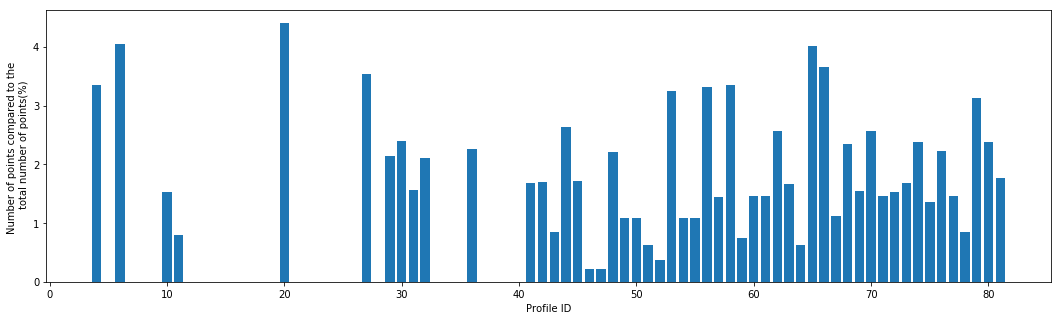

In [6]:
num_point_profile = np.zeros(len(unique_profiles_id))
for i in range(len(unique_profiles_id)):
    num_point_profile[i] = df[df['profile_id']==unique_profiles_id[i]].shape[0]

print('Profile ID with minimum number of points %i and it has %i points' %(unique_profiles_id[np.where(num_point_profile == np.amin(num_point_profile))],
                                                                 min(num_point_profile)))    
f, ax = plt.subplots(figsize=(18,5))
plt.bar(unique_profiles_id, (num_point_profile/df.shape[0])*100)
plt.xlabel('Profile ID')
plt.ylabel('Number of points compared to the \n total number of points(%)')

So as we can see from the graph, that all the profiles have a good amount of points. 

Now we will need to see in each experiment if we can see the interaction between the measured variables. This will help us minimize the number of inputs in our model. To do so, we will see the correlation matrix transposed in a heatmap. Since the experiments are independant, we can generate a randon number and use it to choose a specific experiment and then re-run that cell multiple times to see if there is a behavior that stands out.

The correlation heatmap is for the profile ID 51 and its is index 21


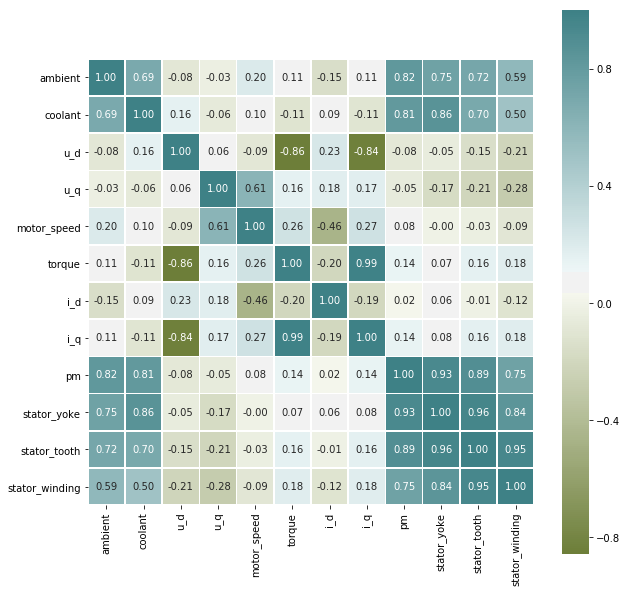

In [7]:
profile = randint(0,len(unique_profiles_id)) # Get a random index

corr=df[df['profile_id']==unique_profiles_id[profile]].drop('profile_id',axis=1).corr()
print('The correlation heatmap is for the profile ID %i and its is index %i'%(unique_profiles_id[profile], profile))

f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', mask= np.zeros_like(corr,dtype=np.bool), 
            cmap=sns.diverging_palette(100,200,as_cmap=True), square=True, ax=ax)

plt.show()

These are the obvious behaviors that keeps coming everytime we run the cell above :
1. There is an almost perfect linear relation between the torque and i_q. This suggest that we can use linear regression model to estimate the torque usinq i_q.
1. The temperatures in stator yoke, tooth and winding are highly correlated since they represent the temperature in the stator and they should be pretty similar (there is no isolation in the stator between those three parts). 
1. The coolant seems to be highly correlated with the stator yoke. It is understandable because the coolant runs through the stator yoke to cool it down.
 

**Torque estimation**

Based on the observation from the heatmap of the correlation matrix, we can use and linear regression model to estimate the torque using the measure of the current i_q. The pair plot between the torque and i_q demonstrate more that linear relation between those two variables. Again, we can run the cell below to go through multiple profiles.

The profile ID shown is 49 and it has 10815 points


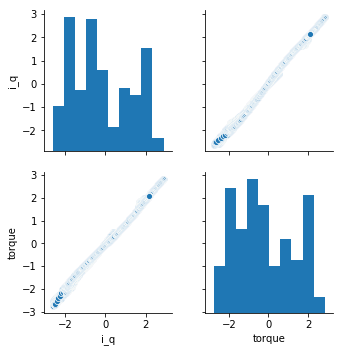

In [8]:
profile = randint(0,len(unique_profiles_id)) # Get a random index 
print('The profile ID shown is %i and it has %i points' %(unique_profiles_id[profile],num_point_profile[profile]))

sns.pairplot(df[df['profile_id']==unique_profiles_id[profile]][['i_q', 'torque']])

Now that we are pretty confident about the structure of the model linking i_q and torque (linear regression model). We will use the data to estimate the coefficient and the intercept of that model. Instead of splitting the values to a train and test dataset, i will try another approach. 
Every data collected in a specific profile represent the operation of the motor. So if we estimate the parameters of the linear model (coefficient and intercept) for every profile then we should have relatively the same parameters.
We will verify that approach but collecting the coefficient, the intercept and the model's score for every profile and then comparing them. Basically, the criteria is the consistency of the estimated parameters and scores.

Text(0, 0.5, 'Score of L.R.')

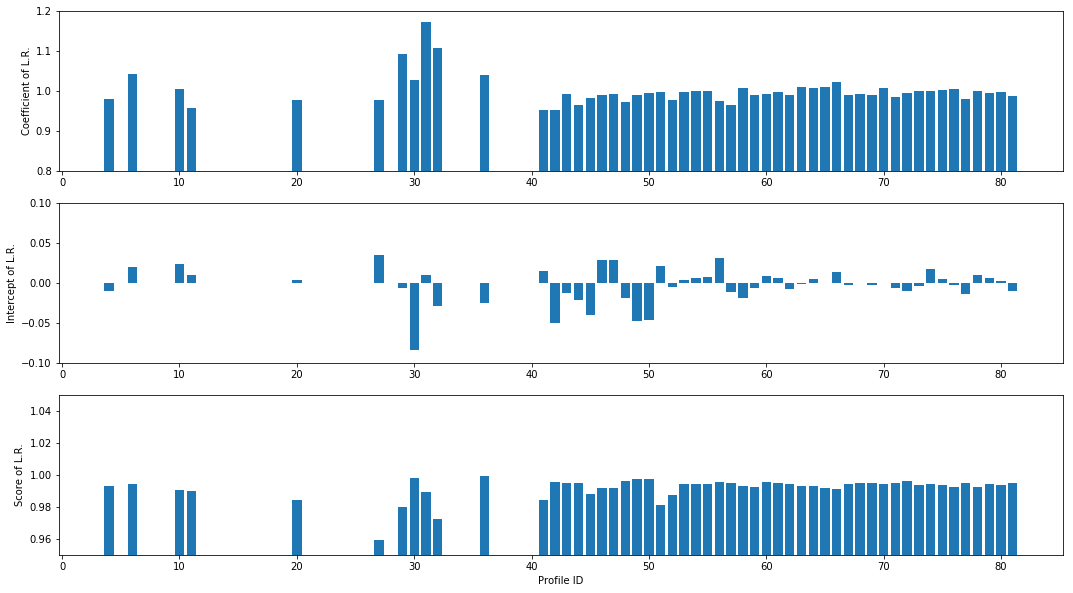

In [9]:
# Torque model

# Define vectors to collect the parameters and the score
model_torque_scores = np.zeros(len(unique_profiles_id))
coef_torque = np.zeros(len(unique_profiles_id))
inter_torque = np.zeros(len(unique_profiles_id))

for i in range (len(unique_profiles_id)) :

    model_torque = LinearRegression()

    X_torque_train = df[df['profile_id']==unique_profiles_id[i]][['i_q']].values
    y_torque_train = df[df['profile_id']==unique_profiles_id[i]][['torque']].values

    model_torque.fit(X_torque_train, y_torque_train)
    
    # Get parameters and the score
    coef_torque[i] = model_torque.coef_
    inter_torque[i] = model_torque.intercept_
    model_torque_scores[i] = model_torque.score(X_torque_train, y_torque_train)

# Representing the models parameters and scores for every profile    
f, ax = plt.subplots(figsize=(18,10))
plt.subplot(3,1,1)
plt.bar(unique_profiles_id, coef_torque)
plt.ylim((0.8,1.2))
plt.ylabel('Coefficient of L.R.')
plt.subplot(3,1,2)
plt.bar(unique_profiles_id, inter_torque)
plt.ylim((-0.1,0.1))
plt.ylabel('Intercept of L.R.')
plt.subplot(3,1,3)    
plt.bar(unique_profiles_id, model_torque_scores)
plt.ylim((0.95,1.05))
plt.xlabel('Profile ID')
plt.ylabel('Score of L.R.')

From the graphs, we can see that for each profile the socres are very high (above 0.95) which means that models explains very well the interaction between i_q and the torque. Regarding the parameters, the estimated parameters are pretty similar and we can confidently say that there is consistency in the values of the estimated parameters. So, an easy/simple way would to get the averages of the estimated coefficients and intercepts and use them as a general model for the estimation of the torque using i_q.

In [10]:
print('The coefficient of the torque model is : %f' %np.mean(coef_torque))
print('The intercept of the torque model is : %f' %np.mean(inter_torque))

The coefficient of the torque model is : 1.001036
The intercept of the torque model is : -0.003240


**Stator Winding temperature**

If we go back to that correlation heatmap, then we can see that there is a strong correlation between the coolant, stator_yoke, stator_tooth and stator_winding. 

The profile ID shown is 43 and it has 8442 points


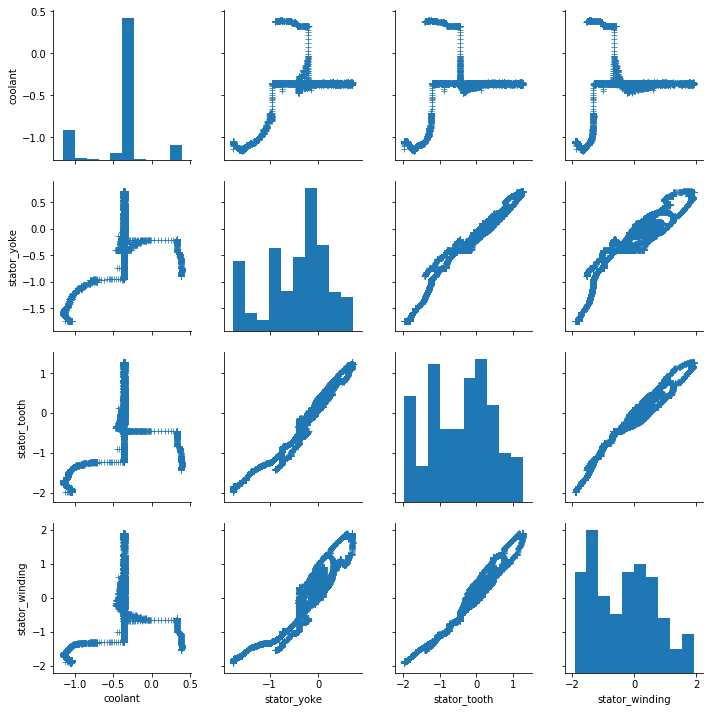

In [11]:
profile = randint(0,len(unique_profiles_id)) # Get a random index 
print('The profile ID shown is %i and it has %i points' %(unique_profiles_id[profile],num_point_profile[profile]))

sns.pairplot(df[df['profile_id']==unique_profiles_id[profile]][['coolant', 'stator_yoke', 'stator_tooth', 'stator_winding']],
            markers ='+' )

The pair-plots show the conclusion that were drawn regarding the relationship between the coolant, stator_yoke, stator_tooth and stator_winding. So we consider using a multi-linear regression model to estimate the stator_winding using the three inputs coolant, stator_yoke and stator_tooth. We will follow the same approach used for the torque model estimation where we will compare the estimated paramters and scores from all the models.

Text(0.5, 0, 'Profile ID')

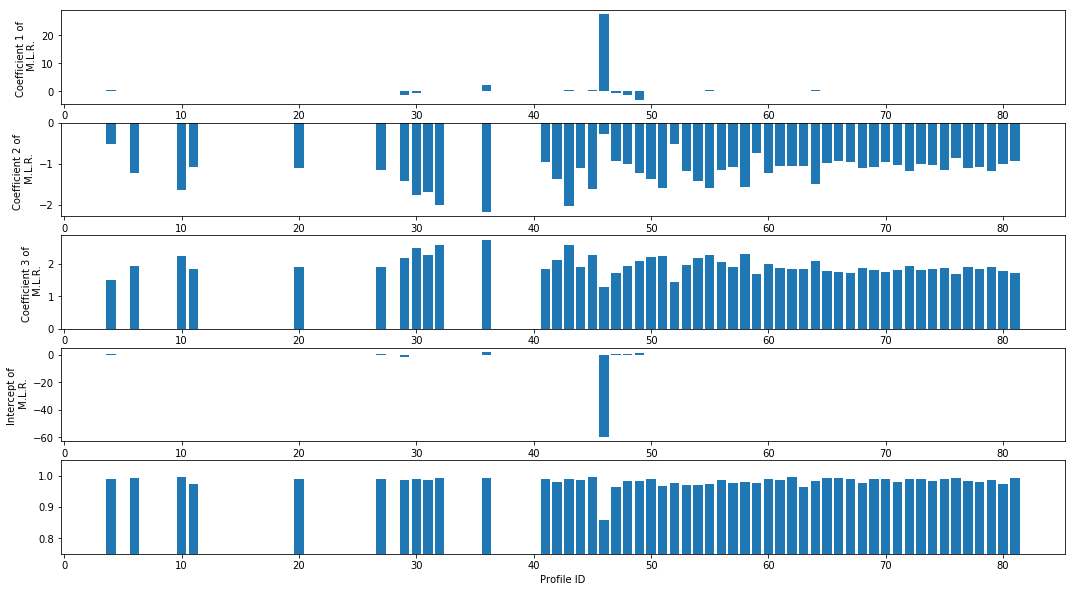

In [12]:
# Stator Temperature

# Define vectors to collect the parameters and the score
model_stator_scores = np.zeros(len(unique_profiles_id))
coef_stator = np.zeros((len(unique_profiles_id),3))
inter_stator = np.zeros(len(unique_profiles_id))

for i in range (len(unique_profiles_id)) :

    model_stator = LinearRegression()

    X_stator_train = df[df['profile_id']==unique_profiles_id[i]][['coolant', 'stator_yoke', 'stator_tooth']].values
    y_stator_train = df[df['profile_id']==unique_profiles_id[i]][['stator_winding']].values

    model_stator.fit(X_stator_train, y_stator_train)
    
    # Get parameters and the score
    coef_stator[i,:] = model_stator.coef_
    inter_stator[i] = model_stator.intercept_
    model_stator_scores[i] = model_stator.score(X_stator_train, y_stator_train)

# Representing the models parameters and scores for every profile    
f, ax = plt.subplots(figsize=(18,10))
plt.subplot(5,1,1)
plt.bar(unique_profiles_id, coef_stator[:,0])
plt.ylabel('Coefficient 1 of \n M.L.R.')
plt.subplot(5,1,2)
plt.bar(unique_profiles_id, coef_stator[:,1])
plt.ylabel('Coefficient 2 of \n M.L.R.')
plt.subplot(5,1,3)
plt.bar(unique_profiles_id, coef_stator[:,2])
plt.ylabel('Coefficient 3 of \n M.L.R.')
plt.subplot(5,1,4)
plt.bar(unique_profiles_id, inter_stator)
plt.ylabel('Intercept of \n M.L.R.')
plt.subplot(5,1,5)
plt.bar(unique_profiles_id, model_stator_scores)
plt.ylim((0.75,1.05))
plt.xlabel('Profile ID')

The consistency of the estimated parameters and score of the multi linear regression model is less evident that the one we had during the estimation of the torque model. One thing that jumps to us when we look at those graphs is the parameters obtained for the profile ID number 46. Even though the score obtained for the profile is about 0.85 (which is still a good score), the value of the parameters is way different than the others. For that reason, we can remove that profile from the estimation of the mean of the parameters because it acts as an outlier profile compared to the other one. After that, we can investigate more about why that profile behaves that way and we did not see that behavior in the torque estimation but it is not the purpose here.

In [13]:
# Calculation the average of the parameters and don't taking into consideration
# the outlier profile
print('The coefficient of the torque model is : %f' %np.mean(np.delete(coef_stator[:,0],16)))
print('The coefficient of the torque model is : %f' %np.mean(np.delete(coef_stator[:,1],16)))
print('The coefficient of the torque model is : %f' %np.mean(np.delete(coef_stator[:,2],16)))
print('The intercept of the torque model is : %f' %np.mean(np.delete(inter_stator,16)))

The coefficient of the torque model is : 0.100654
The coefficient of the torque model is : -1.208705
The coefficient of the torque model is : 1.973363
The intercept of the torque model is : 0.013664


One could argue that there is a little contradiction here if we compare the sign of the coefficient linking the stator_yoke and the stator_winding (which is coefficient 2) and the sign of the correlation between those two variables (you can see it in the correlation heatmap above). So using the correlation heatmap, it is showing a positive correlation which means that if the stator_tooth goes up then the stator_windin goes up too (that is an expected behavior). But the coefficient 2 says the opposite, if the stator_tooh goes up then the stator_winding will go down.
The explanation to that little contradiction is that the parameters estimated in the multi linear regression model have no physical meaning. All what it cares about is to find the correct parameters that describe, the best way it can, the behavior of the stator_winding without taking into consideration the physics behind the collected data.

Hope that you find this kernel interesting and it would give you some hints in whatever you are working on !